# **CNN**

Convolutional Neural Networks (CNNs) are a type of deep learning model specifically designed to process and analyse structured data, such as images or videos. They are particularly effective in tasks like image classification, image recognition and object detection due to their ability to automatically and efficiently learn spatial hierarchies of features.

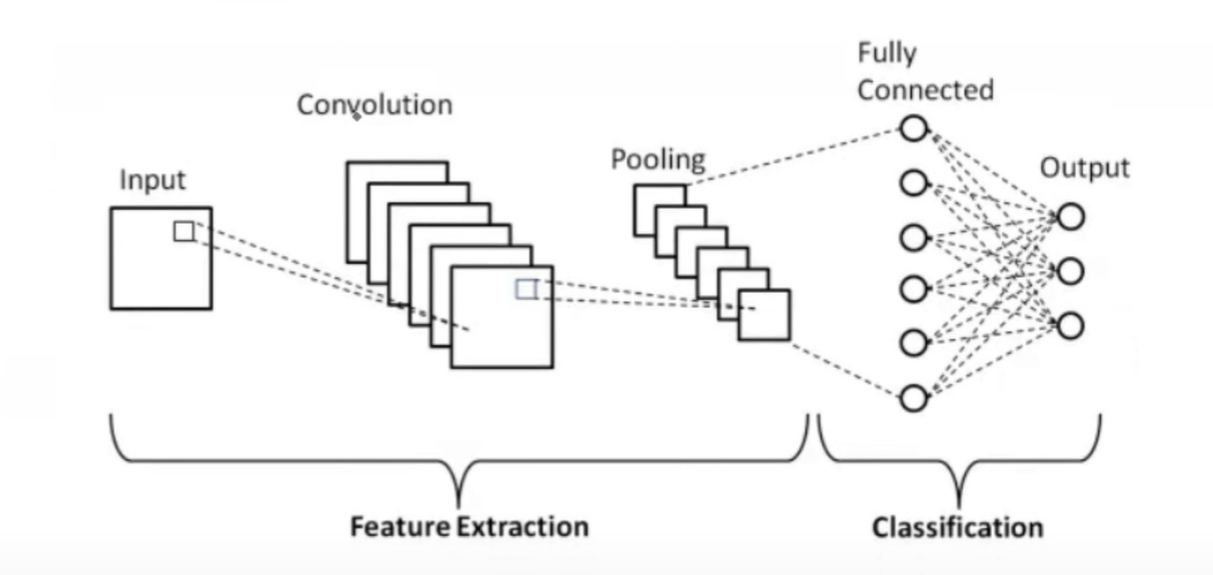

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:",device)

using device: cuda


In [ ]:
torch.manual_seed(42)

In [ ]:
df_train = pd.read_csv("/content/fashion-mnist_train.csv")
print("Shape :",df_train.shape)
df_train.head()

Shape : (60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test = pd.read_csv("/content/fashion-mnist_test.csv")
print("Shape :",df_test.shape)
df_test.head()

Shape : (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


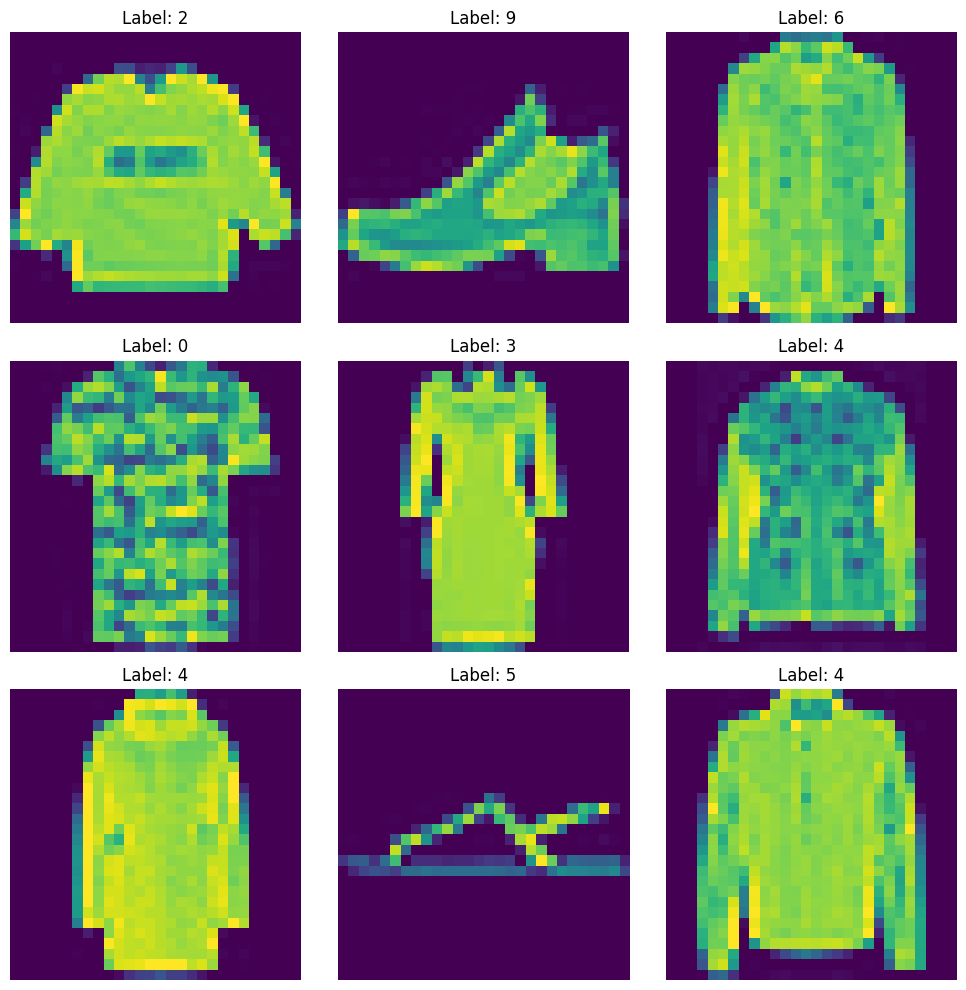

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, ax in enumerate(axes.flat):
    img = df_train.iloc[i , 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.set_title(f"Label: {df_train.iloc[i, 0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
class CustromDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype= torch.float32).reshape(-1,1,28,28)
        self.y = torch.tensor(y, dtype= torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = CustromDataset(X_train, y_train)
test_dataset = CustromDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)  # Increase the batch size and set the pin memory to True
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

len(train_loader), len(test_loader)  # No of Batches

(469, 79)

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.classification(x)
        return x

In [ ]:
learning_rate = 0.01
epochs = 100

In [ ]:
model = MyModel(1)   # No of Image Channel

model = model.to(device)    # Move the model to GPU

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [ ]:
for epoch in range(epochs):
    total_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        loss = loss_function(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 0.9070
Epoch [2/100], Loss: 0.5178
Epoch [3/100], Loss: 0.4295
Epoch [4/100], Loss: 0.3798
Epoch [5/100], Loss: 0.3431
Epoch [6/100], Loss: 0.3184
Epoch [7/100], Loss: 0.3004
Epoch [8/100], Loss: 0.2835
Epoch [9/100], Loss: 0.2651
Epoch [10/100], Loss: 0.2557
Epoch [11/100], Loss: 0.2444
Epoch [12/100], Loss: 0.2328
Epoch [13/100], Loss: 0.2246
Epoch [14/100], Loss: 0.2177
Epoch [15/100], Loss: 0.2069
Epoch [16/100], Loss: 0.2000
Epoch [17/100], Loss: 0.1935
Epoch [18/100], Loss: 0.1828
Epoch [19/100], Loss: 0.1779
Epoch [20/100], Loss: 0.1738
Epoch [21/100], Loss: 0.1669
Epoch [22/100], Loss: 0.1578
Epoch [23/100], Loss: 0.1561
Epoch [24/100], Loss: 0.1498
Epoch [25/100], Loss: 0.1412
Epoch [26/100], Loss: 0.1377
Epoch [27/100], Loss: 0.1339
Epoch [28/100], Loss: 0.1289
Epoch [29/100], Loss: 0.1245
Epoch [30/100], Loss: 0.1201
Epoch [31/100], Loss: 0.1178
Epoch [32/100], Loss: 0.1115
Epoch [33/100], Loss: 0.1089
Epoch [34/100], Loss: 0.1047
Epoch [35/100], Loss: 0

In [ ]:
model.eval()

MyModel(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0

    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model.forward(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 92.84%


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model.forward(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 99.97%
